In [1]:
# config.py
epsilon_energy = 5.0
delta_energy = 5.0
lambda_energy = 1.0
alpha_fgsm = 8 / 255

num_classes = 10
batch_size = 16
epochs = 10
lr = 0.001
device = 'cuda'

In [2]:
# model.py
import torch
import torch.nn as nn
import torchvision.models as models

class ProjHead(nn.Module):
    def __init__(self, in_dim, proj_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, proj_dim)

    def forward(self, x):
        z_prime = self.fc(x)
        energy = torch.sum(z_prime ** 2, dim=1, keepdim=True)
        return z_prime, energy

class ModelWrapper(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        backbone = models.resnet18(pretrained=True)
        backbone.fc = nn.Identity()
        self.model_backbone = backbone
        self.proj_head = ProjHead(512, 512)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        features = self.model_backbone(x)
        z_prime, energy = self.proj_head(features)
        logits = self.classifier(z_prime)
        return logits, energy

In [3]:
# utils.py
import torch
import torch.nn.functional as F
#from config import alpha_fgsm

def fgsm_attack(model, x, y, loss_fn, alpha):
    x_adv = x.detach().clone().requires_grad_(True)
    logits, _ = model(x_adv)
    loss = loss_fn(logits, y)
    loss.backward()
    x_adv = x_adv + alpha * x_adv.grad.sign()
    x_adv = torch.clamp(x_adv, 0, 1)
    return x_adv.detach()

def compute_loss(model, x, y, loss_fn, epsilon, delta, lambda_energy):
    logits_clean, energy_clean = model(x)
    loss_clean = loss_fn(logits_clean, y)

    x_adv = fgsm_attack(model, x, y, loss_fn, alpha_fgsm)
    logits_adv, energy_adv = model(x_adv)
    loss_adv = loss_fn(logits_adv, y)

    loss_energy = lambda_energy * (
        F.relu(energy_clean - epsilon) + 
        F.relu(epsilon + delta - energy_adv)
    ).mean()

    total_loss = loss_clean + loss_adv + loss_energy

    metrics = {
        'L_clean': loss_clean.item(),
        'L_adv': loss_adv.item(),
        'L_energy': loss_energy.item(),
        'E_clean': energy_clean.mean().item(),
        'E_adv': energy_adv.mean().item(),
    }

    return total_loss, metrics

def predict_with_rejection(model, x, epsilon):
    logits, energy = model(x)
    preds = torch.argmax(logits, dim=1)
    rejected = energy.squeeze() > epsilon
    preds[rejected] = -1  # -1 means abstain
    return preds

In [4]:
# train.py
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import ResNet18_Weights
#from model import ModelWrapper
#from utils import compute_loss
#from config import *

# transform_train = transforms.Compose([
#     transforms.Resize(32),
#     # transforms.Normalize(),
#     transforms.ToTensor(),
# ])

# transform_test = transforms.Compose([
#     transforms.Resize(32),
#     # transforms.Normalize(),
#     transforms.ToTensor(),
# ])

train_loader = DataLoader(
    datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.Compose([ResNet18_Weights.IMAGENET1K_V1.transforms()])),
    batch_size=batch_size, shuffle=True)

test_loader = DataLoader(
    datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.Compose([ResNet18_Weights.IMAGENET1K_V1.transforms()])),
    batch_size=batch_size)

In [6]:
model = ModelWrapper(num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
loss_fn = F.cross_entropy

for epoch in range(epochs):
    model.train()
    total_metrics = {'L_clean': 0, 'L_adv': 0, 'L_energy': 0, 'E_clean': 0, 'E_adv': 0}
    progress_bar = tqdm(train_loader, total=len(train_loader))
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss, metrics = compute_loss(model, x, y, loss_fn, epsilon_energy, delta_energy, lambda_energy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for k in total_metrics:
            total_metrics[k] += metrics[k]

        progress_bar.set_postfix(metrics)

    print(f"[Epoch {epoch+1}]")
    for k in total_metrics:
        print(f"  {k}: {total_metrics[k] / len(train_loader):.4f}")

100%|█| 3125/3125 [12:51<00:00,  4.05it/s, L_clean=1.96, L_adv=2.04, L_energy=0.


[Epoch 1]
  L_clean: 1.9861
  L_adv: 1.9598
  L_energy: 0.5504
  E_clean: 2.9204
  E_adv: 28.1676


100%|█| 3125/3125 [12:58<00:00,  4.02it/s, L_clean=1.46, L_adv=1.75, L_energy=0.


[Epoch 2]
  L_clean: 1.2583
  L_adv: 1.4817
  L_energy: 0.0950
  E_clean: 3.1178
  E_adv: 22.3103


100%|█| 3125/3125 [12:58<00:00,  4.01it/s, L_clean=0.623, L_adv=1.41, L_energy=0


[Epoch 3]
  L_clean: 0.7663
  L_adv: 1.1629
  L_energy: 0.0680
  E_clean: 3.2775
  E_adv: 20.9385


100%|█| 3125/3125 [13:00<00:00,  4.01it/s, L_clean=0.158, L_adv=0.44, L_energy=0


[Epoch 4]
  L_clean: 0.5153
  L_adv: 0.9424
  L_energy: 0.0431
  E_clean: 3.2576
  E_adv: 20.1415


100%|█| 3125/3125 [13:00<00:00,  4.00it/s, L_clean=0.884, L_adv=1.32, L_energy=0


[Epoch 5]
  L_clean: 0.4592
  L_adv: 0.9000
  L_energy: 0.0624
  E_clean: 3.2225
  E_adv: 20.3281


100%|█| 3125/3125 [13:05<00:00,  3.98it/s, L_clean=0.296, L_adv=0.597, L_energy=


[Epoch 6]
  L_clean: 0.3089
  L_adv: 0.7191
  L_energy: 0.0271
  E_clean: 3.2197
  E_adv: 19.3670


100%|█| 3125/3125 [13:06<00:00,  3.97it/s, L_clean=0.231, L_adv=0.459, L_energy=


[Epoch 7]
  L_clean: 0.2185
  L_adv: 0.5846
  L_energy: 0.0167
  E_clean: 3.2302
  E_adv: 19.0351


100%|█| 3125/3125 [13:06<00:00,  3.97it/s, L_clean=0.41, L_adv=0.985, L_energy=0


[Epoch 8]
  L_clean: 0.1876
  L_adv: 0.5327
  L_energy: 0.0941
  E_clean: 3.2831
  E_adv: 19.6964


100%|█| 3125/3125 [13:03<00:00,  3.99it/s, L_clean=0.262, L_adv=0.648, L_energy=


[Epoch 9]
  L_clean: 0.1594
  L_adv: 0.4920
  L_energy: 0.0134
  E_clean: 3.2066
  E_adv: 18.6452


100%|█| 3125/3125 [13:02<00:00,  3.99it/s, L_clean=0.19, L_adv=0.589, L_energy=0

[Epoch 10]
  L_clean: 0.0984
  L_adv: 0.3509
  L_energy: 0.0202
  E_clean: 3.2676
  E_adv: 20.7441


In [9]:
torch.save(model.state_dict(), "model.pt")

In [28]:
# evaluate.py
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
# from model import ModelWrapper
# from utils import fgsm_attack, predict_with_rejection
# from config import *

def evaluate(loader, abstention_threshold, examples=float("inf")):
    model = ModelWrapper(num_classes).to(device)
    model.load_state_dict(torch.load("model.pt"))
    model.eval()

    all_clean_E = list()
    all_adv_E = list()
    
    clean_correct = 0
    clean_total = 0
    clean_rejects = 0
    clean_no_defense_correct = 0
    
    robust_correct = 0
    robust_total = 0
    robust_rejects = 0
    robust_no_defense_correct = 0
    
    # with torch.no_grad(): -- prohibited, we need gradients for FGSM attack
    i = -1
    for x, y in tqdm(loader, total=len(loader)):
        i += 1
        if i > examples:
            break
        x, y = x.to(device), y.to(device)
    
        logits_clean, energy_clean = model(x)
        all_clean_E.append(energy_clean.cpu().detach())
        preds_clean = torch.argmax(logits_clean, dim=1)
        reject_clean = (energy_clean.squeeze() > abstention_threshold)
        valid_clean = ~reject_clean
    
        clean_correct += (preds_clean[valid_clean] == y[valid_clean]).sum().item()
        clean_no_defense_correct += (preds_clean == y).sum().item()
        clean_rejects += reject_clean.sum().item()
        clean_total += y.size(0)
    
        x_adv = fgsm_attack(model, x, y, F.cross_entropy, alpha_fgsm)
        logits_adv, energy_adv = model(x_adv)
        all_adv_E.append(energy_adv.cpu().detach())
        preds_adv = torch.argmax(logits_adv, dim=1)
        reject_adv = (energy_adv.squeeze() > abstention_threshold)
        valid_adv = ~reject_adv
    
        robust_correct += (preds_adv[valid_adv] == y[valid_adv]).sum().item()
        robust_no_defense_correct += (preds_adv == y).sum().item()
        robust_rejects += reject_adv.sum().item()
        robust_total += y.size(0)
    
    
    if clean_total == clean_rejects:
        clean_acc = float("NaN")
    else:
        clean_acc = clean_correct / (clean_total - clean_rejects)
    clean_no_def_acc = clean_no_defense_correct / clean_total
    clean_reject_rate = clean_rejects / clean_total
    
    if robust_total == robust_rejects:
        robust_acc = float("NaN")
    else:
        robust_acc = robust_correct / (robust_total - robust_rejects)
    robust_no_def_acc = robust_no_defense_correct / robust_total
    robust_reject_rate = robust_rejects / robust_total
    
    print(f"Clean Accuracy (rejected samples excluded): {clean_acc:.4f}")
    print(f"Clean Accuracy (rejected samples included): {clean_no_def_acc:.4f}")
    print(f"Clean Rejection Rate:       {clean_reject_rate:.4f}")
    print(f"Robust Accuracy (rejected samples excluded): {robust_acc:.4f}")
    print(f"Robust Accuracy (rejected samples included): {robust_no_def_acc:.4f}")
    print(f"Adversarial Detection Rate:  {robust_reject_rate:.4f}")

    all_clean_E = torch.cat(all_clean_E).squeeze().numpy()
    all_adv_E = torch.cat(all_adv_E).squeeze().numpy()
    return all_clean_E, all_adv_E

import matplotlib.pyplot as plt
import numpy as np

def energy_hist(energy_clean, energy_adv, abstention_threshold, binwidth=0.2):
    plt.hist(energy_clean, alpha=0.5, label='Clean Energy', bins=np.arange(min(energy_clean), max(energy_clean) + binwidth, binwidth))
    plt.hist(energy_adv, alpha=0.5, label='Adversarial Energy', bins=np.arange(min(energy_clean), max(energy_clean) + binwidth, binwidth))
    plt.axvline(abstention_threshold, color='red', linestyle='--', label='Abstention Threshold')
    plt.xlabel("Energy")
    plt.ylabel("Count")
    plt.title("Energy Distribution: Clean vs Adversarial")
    plt.legend()
    plt.grid(True)
    plt.show()


In [9]:
train_loader = DataLoader(
    datasets.CIFAR10(root='./data', train=True, download=True,
                     transform=transforms.Compose([ResNet18_Weights.IMAGENET1K_V1.transforms()])),
    batch_size=batch_size)


test_loader = DataLoader(
    datasets.CIFAR10(root='./data', train=False, download=True,
                     transform=transforms.Compose([ResNet18_Weights.IMAGENET1K_V1.transforms()])),
    batch_size=batch_size)

100%|█████████████████████████████████████████| 625/625 [01:35<00:00,  6.54it/s]


Clean Accuracy (rejected samples excluded): 0.8337
Clean Accuracy (rejected samples included): 0.8265
Clean Rejection Rate:       0.7895
Robust Accuracy (rejected samples excluded): 0.3505
Robust Accuracy (rejected samples included): 0.4580
Adversarial Detection Rate:  0.7207


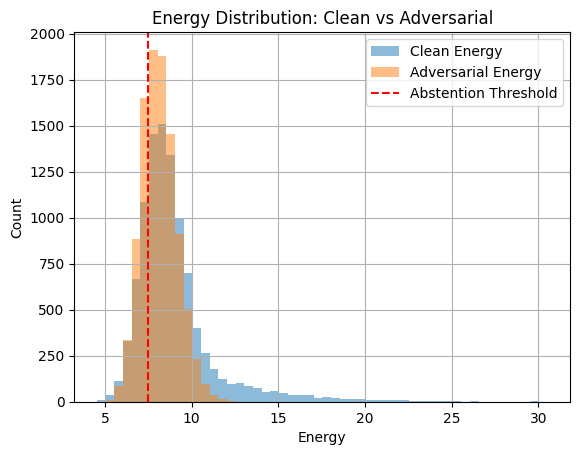

In [26]:
E_clean, E_adv = evaluate(test_loader, epsilon_energy+0.5*delta_energy)
energy_hist(E_clean, E_adv, epsilon_energy+0.5*delta_energy)

 16%|██████▍                                 | 501/3125 [01:15<06:35,  6.63it/s]


Clean Accuracy (rejected samples excluded): 0.9106
Clean Accuracy (rejected samples included): 0.9127
Clean Rejection Rate:       0.8116
Robust Accuracy (rejected samples excluded): 0.3890
Robust Accuracy (rejected samples included): 0.5147
Adversarial Detection Rate:  0.7184


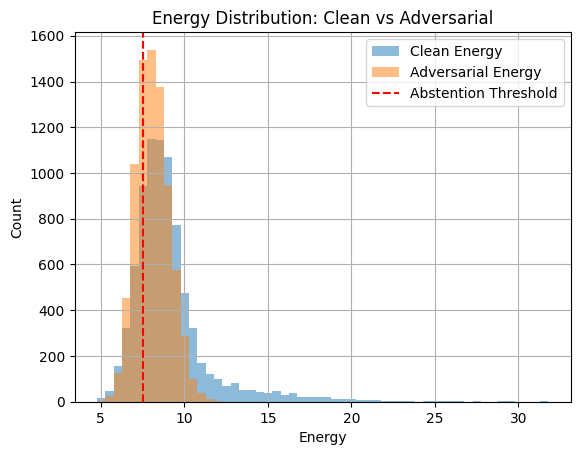

In [27]:
E_clean, E_adv = evaluate(train_loader, epsilon_energy+0.5*delta_energy, examples=500)
energy_hist(E_clean, E_adv, epsilon_energy+0.5*delta_energy)